# Introduction

## Objectif du Notebook
L'objectif de ce notebook est de développer et d'évaluer des modèles avancés d'analyse de sentiments en utilisant des architectures de réseaux de neurones convolutionnels (CNN) et de réseaux de neurones récurrents (LSTM). Ces modèles seront entraînés sur un jeu de données de tweets et utiliseront des embeddings textuels pré-entraînés tels que Word2Vec et FastText pour capturer les relations sémantiques entre les mots.

## Présentation des Méthodes CNN et LSTM
Le Convolutional Neural Network (CNN) et le Long Short-Term Memory (LSTM) sont deux types d'architectures de réseaux de neurones particulièrement adaptées au traitement des données séquentielles telles que le texte.

### CNN (Convolutional Neural Network)
Les CNN sont bien connus pour leur capacité à détecter des motifs locaux dans les données séquentielles, ce qui les rend efficaces pour capturer des n-grams de mots dans les textes. Dans ce notebook, nous utiliserons un CNN pour analyser les séquences de mots des tweets et en extraire des caractéristiques pertinentes pour la classification de sentiments.

### LSTM (Long Short-Term Memory)
Les LSTM sont un type de réseau de neurones récurrents (RNN) capable de capturer des dépendances à long terme dans des séquences de données. Cela les rend particulièrement efficaces pour comprendre le contexte complet d'une phrase ou d'un tweet, en tenant compte de l'ordre des mots et des relations temporelles.

## Plan du Notebook
Ce notebook est structuré de manière à suivre un pipeline complet de traitement des données, d'entraînement des modèles et d'évaluation des performances :
1. **Chargement et Préparation des Données** : Nous allons commencer par charger les données, les nettoyer, les tokeniser et les préparer pour les modèles CNN et LSTM.
2. **Préparation des Embeddings Textuels** : Nous utiliserons Word2Vec et FastText pour convertir les séquences de mots en vecteurs denses.
3. **Construction du Modèle CNN** : Nous définirons un modèle CNN pour la tâche de classification de sentiments.
4. **Construction du Modèle LSTM** : Nous définirons un modèle LSTM pour la même tâche.
5. **Entrainement des modèles** : Nous entrainerons les deux modèles.
6. **Comparaison des modèles** : Nous allons comparer les différents modèles.
7. **Export du meilleur modèle** : Nous allons exporter le modèle le plus performant pour notre analyse des sentiments.


# 1. Chargement et Préparation des Données

## 1.1 Importation des bibliothèques nécessaires


In [4]:
import numpy as np
import pandas as pd
import mlflow
import mlflow.keras
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim.downloader as api
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


## 1.2 Chargement des données et transformation de la cible target


In [6]:
# Charger les données
data = pd.read_csv('../data/database_p7_rework.csv')

# Transformation des labels : 0 reste 0 et 4 devient 1
data['target_binary'] = data['target'].apply(lambda x: 0 if x == 0 else 1)

# Vérification des transformations
print("Unique values in target_binary:", data['target_binary'].unique())



Unique values in target_binary: [0 1]


## 1.3 Tokenisation

In [8]:
# Fonction pour préparer les séquences
def prepare_sequences(texts, tokenizer, maxlen=25):
    sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(sequences, maxlen=maxlen)

# Tokenization
tokenizer_lemma = Tokenizer(num_words=5000)
tokenizer_lemma.fit_on_texts(data['text_lemmatized'])

tokenizer_stem = Tokenizer(num_words=5000)
tokenizer_stem.fit_on_texts(data['text_stemmed'])

# Préparation des séquences
X_lemma = prepare_sequences(data['text_lemmatized'], tokenizer_lemma)
X_stem = prepare_sequences(data['text_stemmed'], tokenizer_stem)

# Séparation des données
y = data['target_binary']

X_train_lemma, X_test_lemma, y_train_lemma, y_test_lemma = train_test_split(X_lemma, y, test_size=0.2, random_state=42)
X_train_stem, X_test_stem, y_train_stem, y_test_stem = train_test_split(X_stem, y, test_size=0.2, random_state=42)

# 2 Préparation des Embeddings Textuels

In [10]:
# Charger les modèles Word2Vec et FastText pré-entraînés (300 dimensions)
w2v_model = api.load('word2vec-google-news-300')
ft_model = api.load('fasttext-wiki-news-subwords-300')

# Fonction pour créer la matrice d'embeddings
def create_embedding_matrix(tokenizer, embedding_model, embedding_dim=300):
    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if word in embedding_model:
            embedding_matrix[i] = embedding_model[word]
    return embedding_matrix

# Créer les matrices d'embeddings
embedding_matrix_lemma_w2v = create_embedding_matrix(tokenizer_lemma, w2v_model)
embedding_matrix_stem_w2v = create_embedding_matrix(tokenizer_stem, w2v_model)

embedding_matrix_lemma_ft = create_embedding_matrix(tokenizer_lemma, ft_model)
embedding_matrix_stem_ft = create_embedding_matrix(tokenizer_stem, ft_model)


# 3. Définition de l'architecture du modèle CNN

In [12]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

# Fonction pour créer un modèle CNN
def create_cnn_model(input_dim, embedding_matrix, max_length=100):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=embedding_matrix.shape[1], weights=[embedding_matrix], input_length=max_length, trainable=False))
    model.add(Conv1D(128, kernel_size=5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model




# 4. Définition de l'architecture du modèle LSTM

In [14]:
from keras.layers import LSTM, Bidirectional

# Fonction pour créer un modèle LSTM
def create_lstm_model(input_dim, embedding_matrix, max_length=100):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=embedding_matrix.shape[1], weights=[embedding_matrix], input_length=max_length, trainable=False))
    model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model



# 5. Entraînement et Évaluation des Modèles

## 5.1 Entraînement des Modèles CNN et LSTM avec les Embeddings Word2Vec + lemmatisation

D:\Master_Openclassroom\python\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 84s 5ms/step - accuracy: 0.7748 - loss: 0.4697 - val_accuracy: 0.8020 - val_loss: 0.4270
Epoch 2/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 80s 5ms/step - accuracy: 0.8094 - loss: 0.4141 - val_accuracy: 0.8066 - val_loss: 0.4205
Epoch 3/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 78s 5ms/step - accuracy: 0.8189 - loss: 0.3970 - val_accuracy: 0.8076 - val_loss: 0.4158
Epoch 4/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 74s 5ms/step - accuracy: 0.8273 - loss: 0.3814 - val_accuracy: 0.8080 - val_loss: 0.4188
Epoch 5/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 73s 5ms/step - accuracy: 0.8331 - loss: 0.3699 - val_accuracy: 0.8077 - val_loss: 0.4174
Epoch 6/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 73s 5ms/step - accuracy: 0.8385 - loss: 0.3592 - val_accuracy: 0.8075 - val_loss: 0.4343
Epoch 7/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 74s 5ms/step - accuracy: 0.8424 - loss: 0.3510 - val_accuracy: 0.8059 - val_loss: 0.4278
Epoch 8/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 74s 5ms/step - accuracy: 

2024/09/02 17:38:17 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/09/02 17:38:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


9990/9990 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step


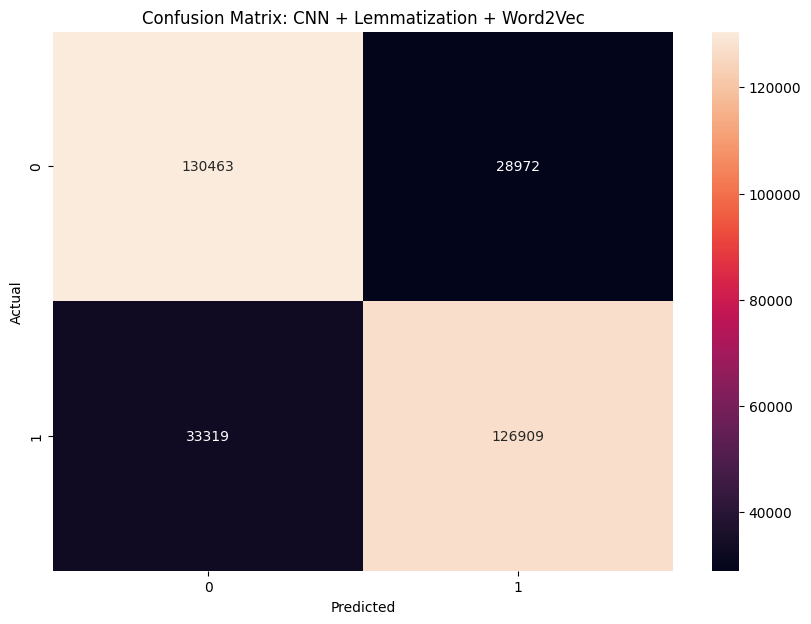

In [105]:
import mlflow
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Définir le dossier racine où vous voulez enregistrer les artefacts MLflow
base_dir = os.path.abspath(os.path.join("..", "mlruns"))

# Exemple pour CNN avec lemmatisation + Word2Vec
model_name = "cnn_model_lemma_w2v"
mlflow_base_dir = os.path.join(base_dir, model_name)

# Assurez-vous que le dossier existe
if not os.path.exists(mlflow_base_dir):
    os.makedirs(mlflow_base_dir)

# Configurer MLflow pour utiliser ce dossier comme URI de suivi
mlflow.set_tracking_uri(f"file:///{mlflow_base_dir.replace(os.sep, '/')}")

# Créer une nouvelle expérience MLflow ou utiliser une expérience existante
mlflow.set_experiment(model_name)

with mlflow.start_run():
    # Créer et entraîner le modèle
    cnn_model_lemma_w2v = create_cnn_model(len(tokenizer_lemma.word_index) + 1, embedding_matrix_lemma_w2v)
    cnn_model_lemma_w2v.fit(X_train_lemma, y_train_lemma, batch_size=64, epochs=10, validation_split=0.2, verbose=1)

    # Enregistrer le modèle dans MLflow
    mlflow.keras.log_model(cnn_model_lemma_w2v, model_name)

    # Faire des prédictions et évaluer le modèle
    y_pred_lemma_w2v = (cnn_model_lemma_w2v.predict(X_test_lemma) > 0.5).astype("int32")
    accuracy_lemma_w2v = accuracy_score(y_test_lemma, y_pred_lemma_w2v)
    precision_lemma_w2v = precision_score(y_test_lemma, y_pred_lemma_w2v)
    recall_lemma_w2v = recall_score(y_test_lemma, y_pred_lemma_w2v)
    f1_lemma_w2v = f1_score(y_test_lemma, y_pred_lemma_w2v)

    # Enregistrer les métriques dans MLflow
    mlflow.log_metric("accuracy_lemma_w2v", accuracy_lemma_w2v)
    mlflow.log_metric("precision_lemma_w2v", precision_lemma_w2v)
    mlflow.log_metric("recall_lemma_w2v", recall_lemma_w2v)
    mlflow.log_metric("f1_lemma_w2v", f1_lemma_w2v)

    # Créer et afficher la matrice de confusion
    cm_lemma_w2v = confusion_matrix(y_test_lemma, y_pred_lemma_w2v)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm_lemma_w2v, annot=True, fmt='d')
    plt.title("Confusion Matrix: CNN + Lemmatization + Word2Vec")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


D:\Master_Openclassroom\python\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 330s 20ms/step - accuracy: 0.7633 - loss: 0.4868 - val_accuracy: 0.8096 - val_loss: 0.4132
Epoch 2/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 299s 19ms/step - accuracy: 0.8083 - loss: 0.4172 - val_accuracy: 0.8166 - val_loss: 0.4026
Epoch 3/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 285s 18ms/step - accuracy: 0.8183 - loss: 0.3986 - val_accuracy: 0.8223 - val_loss: 0.3908
Epoch 4/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 290s 18ms/step - accuracy: 0.8251 - loss: 0.3870 - val_accuracy: 0.8238 - val_loss: 0.3888
Epoch 5/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 295s 18ms/step - accuracy: 0.8290 - loss: 0.3799 - val_accuracy: 0.8266 - val_loss: 0.3843
Epoch 6/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 299s 19ms/step - accuracy: 0.8318 - loss: 0.3740 - val_accuracy: 0.8274 - val_loss: 0.3853
Epoch 7/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 312s 20ms/step - accuracy: 0.8345 - loss: 0.3692 - val_accuracy: 0.8280 - val_loss: 0.3855
Epoch 8/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 328s 21ms/s

2024/09/02 19:15:28 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/09/02 19:15:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


9990/9990 ━━━━━━━━━━━━━━━━━━━━ 64s 6ms/step


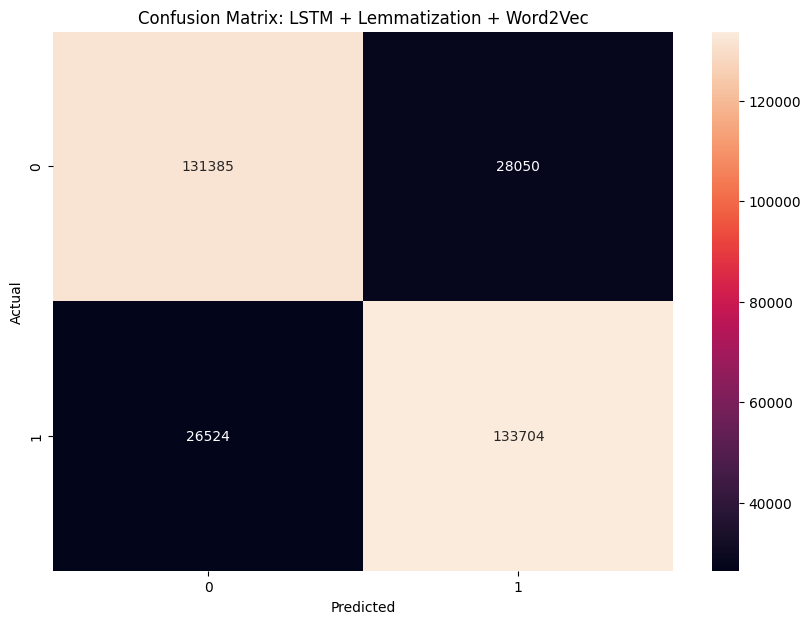

In [109]:
# Exemple pour LSTM avec lemmatisation + Word2Vec
model_name = "lstm_model_lemma_w2v"
mlflow_base_dir = os.path.join(base_dir, model_name)

if not os.path.exists(mlflow_base_dir):
    os.makedirs(mlflow_base_dir)

mlflow.set_tracking_uri(f"file:///{mlflow_base_dir.replace(os.sep, '/')}")

mlflow.set_experiment(model_name)

with mlflow.start_run():
    lstm_model_lemma_w2v = create_lstm_model(len(tokenizer_lemma.word_index) + 1, embedding_matrix_lemma_w2v)
    lstm_model_lemma_w2v.fit(X_train_lemma, y_train_lemma, batch_size=64, epochs=10, validation_split=0.2, verbose=1)

    mlflow.keras.log_model(lstm_model_lemma_w2v, model_name)

    y_pred_lemma_w2v = (lstm_model_lemma_w2v.predict(X_test_lemma) > 0.5).astype("int32")
    lstm_accuracy_lemma_w2v = accuracy_score(y_test_lemma, y_pred_lemma_w2v)
    lstm_precision_lemma_w2v = precision_score(y_test_lemma, y_pred_lemma_w2v)
    lstm_recall_lemma_w2v = recall_score(y_test_lemma, y_pred_lemma_w2v)
    lstm_f1_lemma_w2v = f1_score(y_test_lemma, y_pred_lemma_w2v)

    mlflow.log_metrics({
        "accuracy": lstm_accuracy_lemma_w2v,
        "precision": lstm_precision_lemma_w2v,
        "recall": lstm_recall_lemma_w2v,
        "f1_score": lstm_f1_lemma_w2v
    })

    cm_lemma_w2v = confusion_matrix(y_test_lemma, y_pred_lemma_w2v)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_lemma_w2v, annot=True, fmt='d')
    plt.title("Confusion Matrix: LSTM + Lemmatization + Word2Vec")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


## 5.2 Entraînement des Modèles CNN et LSTM avec les Embeddings FastText + lemmatisation

D:\Master_Openclassroom\python\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 75s 5ms/step - accuracy: 0.7697 - loss: 0.4770 - val_accuracy: 0.7982 - val_loss: 0.4341
Epoch 2/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 73s 5ms/step - accuracy: 0.8062 - loss: 0.4202 - val_accuracy: 0.8073 - val_loss: 0.4195
Epoch 3/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 73s 5ms/step - accuracy: 0.8146 - loss: 0.4049 - val_accuracy: 0.8092 - val_loss: 0.4149
Epoch 4/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 76s 5ms/step - accuracy: 0.8207 - loss: 0.3934 - val_accuracy: 0.8112 - val_loss: 0.4155
Epoch 5/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 74s 5ms/step - accuracy: 0.8247 - loss: 0.3855 - val_accuracy: 0.8090 - val_loss: 0.4162
Epoch 6/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 76s 5ms/step - accuracy: 0.8291 - loss: 0.3781 - val_accuracy: 0.8103 - val_loss: 0.4200
Epoch 7/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 76s 5ms/step - accuracy: 0.8325 - loss: 0.3714 - val_accuracy: 0.8098 - val_loss: 0.4179
Epoch 8/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 77s 5ms/step - accuracy: 

2024/09/02 17:51:21 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/09/02 17:51:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


9990/9990 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step


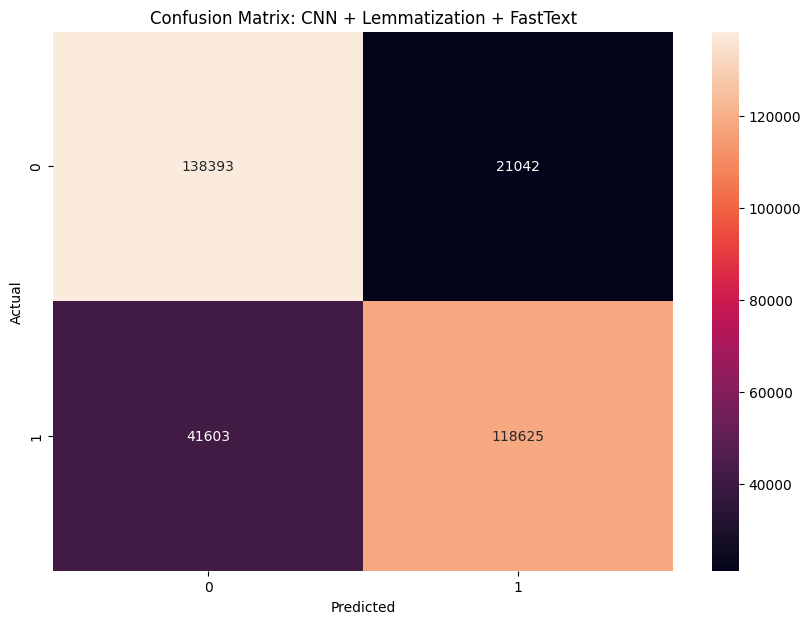

In [106]:
# Exemple pour CNN avec lemmatisation + FastText
model_name = "cnn_model_lemma_ft"
mlflow_base_dir = os.path.join(base_dir, model_name)

# Assurez-vous que le dossier existe
if not os.path.exists(mlflow_base_dir):
    os.makedirs(mlflow_base_dir)

mlflow.set_tracking_uri(f"file:///{mlflow_base_dir.replace(os.sep, '/')}")

mlflow.set_experiment(model_name)

with mlflow.start_run():
    cnn_model_lemma_ft = create_cnn_model(len(tokenizer_lemma.word_index) + 1, embedding_matrix_lemma_ft)
    cnn_model_lemma_ft.fit(X_train_lemma, y_train_lemma, batch_size=64, epochs=10, validation_split=0.2, verbose=1)

    mlflow.keras.log_model(cnn_model_lemma_ft, model_name)

    y_pred_lemma_ft = (cnn_model_lemma_ft.predict(X_test_lemma) > 0.5).astype("int32")
    cnn_accuracy_lemma_ft = accuracy_score(y_test_lemma, y_pred_lemma_ft)
    cnn_precision_lemma_ft = precision_score(y_test_lemma, y_pred_lemma_ft)
    cnn_recall_lemma_ft = recall_score(y_test_lemma, y_pred_lemma_ft)
    cnn_f1_lemma_ft = f1_score(y_test_lemma, y_pred_lemma_ft)

    mlflow.log_metrics({
        "accuracy": cnn_accuracy_lemma_ft,
        "precision": cnn_precision_lemma_ft,
        "recall": cnn_recall_lemma_ft,
        "f1_score": cnn_f1_lemma_ft
    })

    cm_lemma_ft = confusion_matrix(y_test_lemma, y_pred_lemma_ft)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_lemma_ft, annot=True, fmt='d')
    plt.title("Confusion Matrix: CNN + Lemmatization + FastText")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


D:\Master_Openclassroom\python\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 366s 23ms/step - accuracy: 0.7550 - loss: 0.4999 - val_accuracy: 0.8013 - val_loss: 0.4260
Epoch 2/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 345s 22ms/step - accuracy: 0.8009 - loss: 0.4294 - val_accuracy: 0.8134 - val_loss: 0.4071
Epoch 3/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 361s 23ms/step - accuracy: 0.8120 - loss: 0.4113 - val_accuracy: 0.8177 - val_loss: 0.4006
Epoch 4/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 371s 23ms/step - accuracy: 0.8185 - loss: 0.3990 - val_accuracy: 0.8219 - val_loss: 0.3919
Epoch 5/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 388s 24ms/step - accuracy: 0.8217 - loss: 0.3920 - val_accuracy: 0.8238 - val_loss: 0.3906
Epoch 6/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 413s 26ms/step - accuracy: 0.8265 - loss: 0.3848 - val_accuracy: 0.8258 - val_loss: 0.3867
Epoch 7/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 443s 28ms/step - accuracy: 0.8288 - loss: 0.3801 - val_accuracy: 0.8256 - val_loss: 0.3864
Epoch 8/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 464s 29ms/s

2024/09/02 20:25:43 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/09/02 20:25:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


9990/9990 ━━━━━━━━━━━━━━━━━━━━ 77s 8ms/step


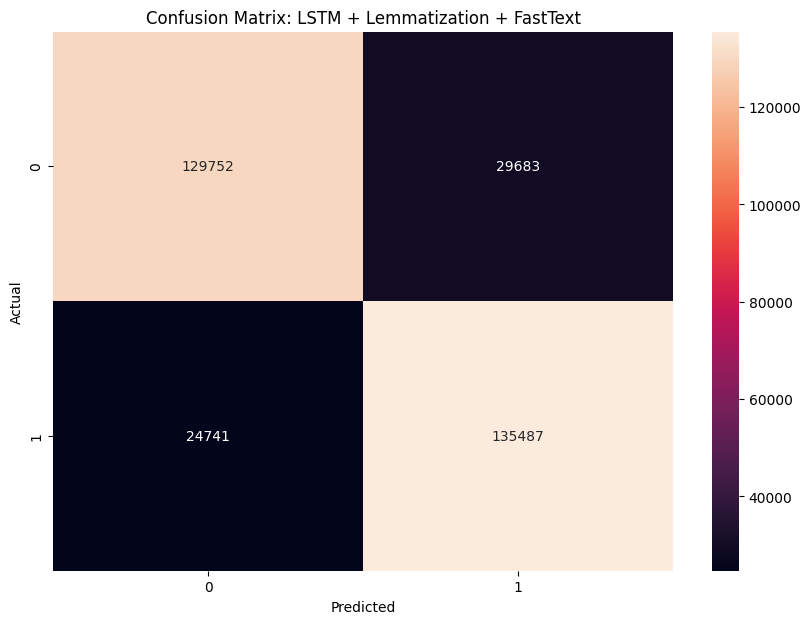

In [110]:
# Exemple pour LSTM avec lemmatisation + FastText
model_name = "lstm_model_lemma_ft"
mlflow_base_dir = os.path.join(base_dir, model_name)

if not os.path.exists(mlflow_base_dir):
    os.makedirs(mlflow_base_dir)

mlflow.set_tracking_uri(f"file:///{mlflow_base_dir.replace(os.sep, '/')}")

mlflow.set_experiment(model_name)

with mlflow.start_run():
    lstm_model_lemma_ft = create_lstm_model(len(tokenizer_lemma.word_index) + 1, embedding_matrix_lemma_ft)
    lstm_model_lemma_ft.fit(X_train_lemma, y_train_lemma, batch_size=64, epochs=10, validation_split=0.2, verbose=1)

    mlflow.keras.log_model(lstm_model_lemma_ft, model_name)

    y_pred_lemma_ft = (lstm_model_lemma_ft.predict(X_test_lemma) > 0.5).astype("int32")
    lstm_accuracy_lemma_ft = accuracy_score(y_test_lemma, y_pred_lemma_ft)
    lstm_precision_lemma_ft = precision_score(y_test_lemma, y_pred_lemma_ft)
    lstm_recall_lemma_ft = recall_score(y_test_lemma, y_pred_lemma_ft)
    lstm_f1_lemma_ft = f1_score(y_test_lemma, y_pred_lemma_ft)

    mlflow.log_metrics({
        "accuracy": lstm_accuracy_lemma_ft,
        "precision": lstm_precision_lemma_ft,
        "recall": lstm_recall_lemma_ft,
        "f1_score": lstm_f1_lemma_ft
    })

    cm_lemma_ft = confusion_matrix(y_test_lemma, y_pred_lemma_ft)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_lemma_ft, annot=True, fmt='d')
    plt.title("Confusion Matrix: LSTM + Lemmatization + FastText")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


## 5.3 Entraînement des Modèles CNN et LSTM avec les Embeddings Word2Vec + stemming

D:\Master_Openclassroom\python\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 75s 5ms/step - accuracy: 0.7606 - loss: 0.4914 - val_accuracy: 0.7820 - val_loss: 0.4578
Epoch 2/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 75s 5ms/step - accuracy: 0.7963 - loss: 0.4352 - val_accuracy: 0.7946 - val_loss: 0.4382
Epoch 3/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 78s 5ms/step - accuracy: 0.8084 - loss: 0.4159 - val_accuracy: 0.7959 - val_loss: 0.4400
Epoch 4/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 84s 5ms/step - accuracy: 0.8150 - loss: 0.4026 - val_accuracy: 0.7966 - val_loss: 0.4350
Epoch 5/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 85s 5ms/step - accuracy: 0.8225 - loss: 0.3896 - val_accuracy: 0.7972 - val_loss: 0.4368
Epoch 6/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 89s 6ms/step - accuracy: 0.8263 - loss: 0.3808 - val_accuracy: 0.7963 - val_loss: 0.4405
Epoch 7/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 93s 6ms/step - accuracy: 0.8306 - loss: 0.3715 - val_accuracy: 0.7957 - val_loss: 0.4407
Epoch 8/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 94s 6ms/step - accuracy: 

2024/09/02 18:06:17 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/09/02 18:06:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


9990/9990 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step


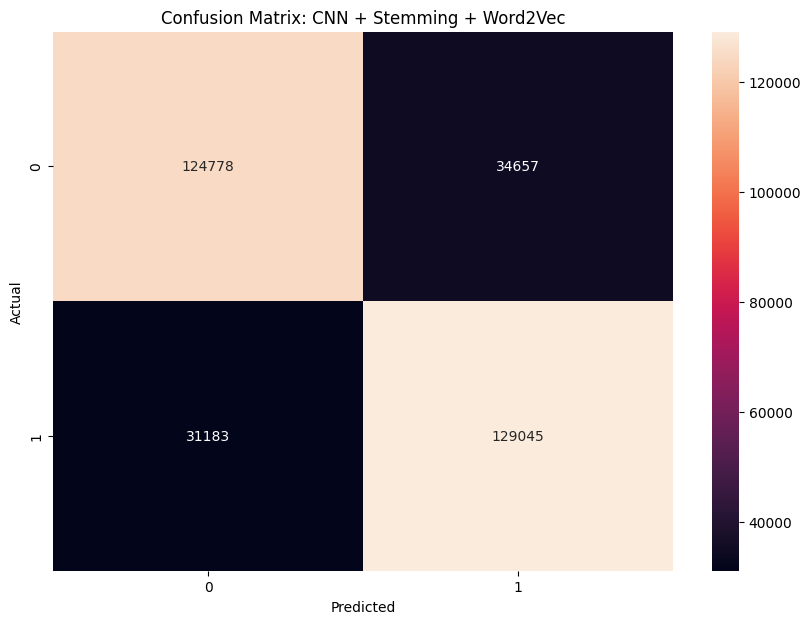

In [107]:
# Exemple pour CNN avec stemming + Word2Vec
model_name = "cnn_model_stem_w2v"
mlflow_base_dir = os.path.join(base_dir, model_name)

if not os.path.exists(mlflow_base_dir):
    os.makedirs(mlflow_base_dir)

mlflow.set_tracking_uri(f"file:///{mlflow_base_dir.replace(os.sep, '/')}")

mlflow.set_experiment(model_name)

with mlflow.start_run():
    cnn_model_stem_w2v = create_cnn_model(len(tokenizer_stem.word_index) + 1, embedding_matrix_stem_w2v)
    cnn_model_stem_w2v.fit(X_train_stem, y_train_stem, batch_size=64, epochs=10, validation_split=0.2, verbose=1)

    mlflow.keras.log_model(cnn_model_stem_w2v, model_name)

    y_pred_stem_w2v = (cnn_model_stem_w2v.predict(X_test_stem) > 0.5).astype("int32")
    cnn_accuracy_stem_w2v = accuracy_score(y_test_stem, y_pred_stem_w2v)
    cnn_precision_stem_w2v = precision_score(y_test_stem, y_pred_stem_w2v)
    cnn_recall_stem_w2v = recall_score(y_test_stem, y_pred_stem_w2v)
    cnn_f1_stem_w2v = f1_score(y_test_stem, y_pred_stem_w2v)

    mlflow.log_metrics({
        "accuracy": cnn_accuracy_stem_w2v,
        "precision": cnn_precision_stem_w2v,
        "recall": cnn_recall_stem_w2v,
        "f1_score": cnn_f1_stem_w2v
    })

    cm_stem_w2v = confusion_matrix(y_test_stem, y_pred_stem_w2v)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_stem_w2v, annot=True, fmt='d')
    plt.title("Confusion Matrix: CNN + Stemming + Word2Vec")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


D:\Master_Openclassroom\python\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 522s 32ms/step - accuracy: 0.7500 - loss: 0.5058 - val_accuracy: 0.7968 - val_loss: 0.4346
Epoch 2/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 517s 32ms/step - accuracy: 0.7962 - loss: 0.4365 - val_accuracy: 0.8066 - val_loss: 0.4183
Epoch 3/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 520s 33ms/step - accuracy: 0.8066 - loss: 0.4198 - val_accuracy: 0.8116 - val_loss: 0.4103
Epoch 4/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 528s 33ms/step - accuracy: 0.8126 - loss: 0.4082 - val_accuracy: 0.8139 - val_loss: 0.4075
Epoch 5/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 530s 33ms/step - accuracy: 0.8164 - loss: 0.4009 - val_accuracy: 0.8158 - val_loss: 0.4034
Epoch 6/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 538s 34ms/step - accuracy: 0.8202 - loss: 0.3937 - val_accuracy: 0.8166 - val_loss: 0.4023
Epoch 7/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 547s 34ms/step - accuracy: 0.8230 - loss: 0.3891 - val_accuracy: 0.8178 - val_loss: 0.4003
Epoch 8/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 558s 35ms/s

2024/09/02 21:58:24 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/09/02 21:58:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


9990/9990 ━━━━━━━━━━━━━━━━━━━━ 117s 12ms/step


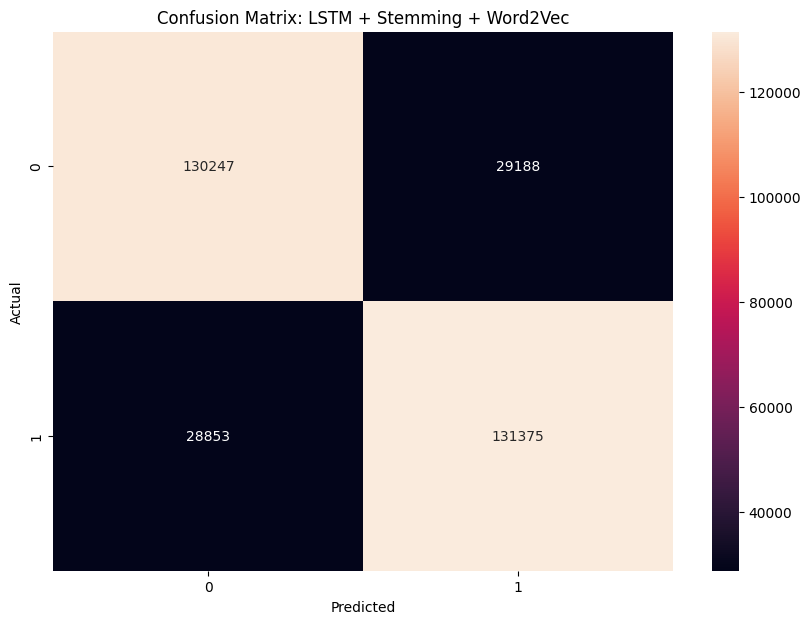

In [111]:
# Exemple pour LSTM avec stemming + Word2Vec
model_name = "lstm_model_stem_w2v"
mlflow_base_dir = os.path.join(base_dir, model_name)

if not os.path.exists(mlflow_base_dir):
    os.makedirs(mlflow_base_dir)

mlflow.set_tracking_uri(f"file:///{mlflow_base_dir.replace(os.sep, '/')}")

mlflow.set_experiment(model_name)

with mlflow.start_run():
    lstm_model_stem_w2v = create_lstm_model(len(tokenizer_stem.word_index) + 1, embedding_matrix_stem_w2v)
    lstm_model_stem_w2v.fit(X_train_stem, y_train_stem, batch_size=64, epochs=10, validation_split=0.2, verbose=1)

    mlflow.keras.log_model(lstm_model_stem_w2v, model_name)

    y_pred_stem_w2v = (lstm_model_stem_w2v.predict(X_test_stem) > 0.5).astype("int32")
    lstm_accuracy_stem_w2v = accuracy_score(y_test_stem, y_pred_stem_w2v)
    lstm_precision_stem_w2v = precision_score(y_test_stem, y_pred_stem_w2v)
    lstm_recall_stem_w2v = recall_score(y_test_stem, y_pred_stem_w2v)
    lstm_f1_stem_w2v = f1_score(y_test_stem, y_pred_stem_w2v)

    mlflow.log_metrics({
        "accuracy": lstm_accuracy_stem_w2v,
        "precision": lstm_precision_stem_w2v,
        "recall": lstm_recall_stem_w2v,
        "f1_score": lstm_f1_stem_w2v
    })

    cm_stem_w2v = confusion_matrix(y_test_stem, y_pred_stem_w2v)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_stem_w2v, annot=True, fmt='d')
    plt.title("Confusion Matrix: LSTM + Stemming + Word2Vec")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


## 5.4 Entraînement des Modèles CNN et LSTM avec les Embeddings FastText + stemming

D:\Master_Openclassroom\python\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 94s 6ms/step - accuracy: 0.7561 - loss: 0.4969 - val_accuracy: 0.7894 - val_loss: 0.4481
Epoch 2/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 94s 6ms/step - accuracy: 0.7938 - loss: 0.4407 - val_accuracy: 0.7958 - val_loss: 0.4381
Epoch 3/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 91s 6ms/step - accuracy: 0.8028 - loss: 0.4241 - val_accuracy: 0.7988 - val_loss: 0.4334
Epoch 4/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 90s 6ms/step - accuracy: 0.8088 - loss: 0.4132 - val_accuracy: 0.8000 - val_loss: 0.4312
Epoch 5/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 86s 5ms/step - accuracy: 0.8143 - loss: 0.4043 - val_accuracy: 0.8000 - val_loss: 0.4306
Epoch 6/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 91s 6ms/step - accuracy: 0.8185 - loss: 0.3964 - val_accuracy: 0.8006 - val_loss: 0.4317
Epoch 7/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 91s 6ms/step - accuracy: 0.8213 - loss: 0.3903 - val_accuracy: 0.7999 - val_loss: 0.4327
Epoch 8/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 89s 6ms/step - accuracy: 

2024/09/02 18:22:04 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/09/02 18:22:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


9990/9990 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step


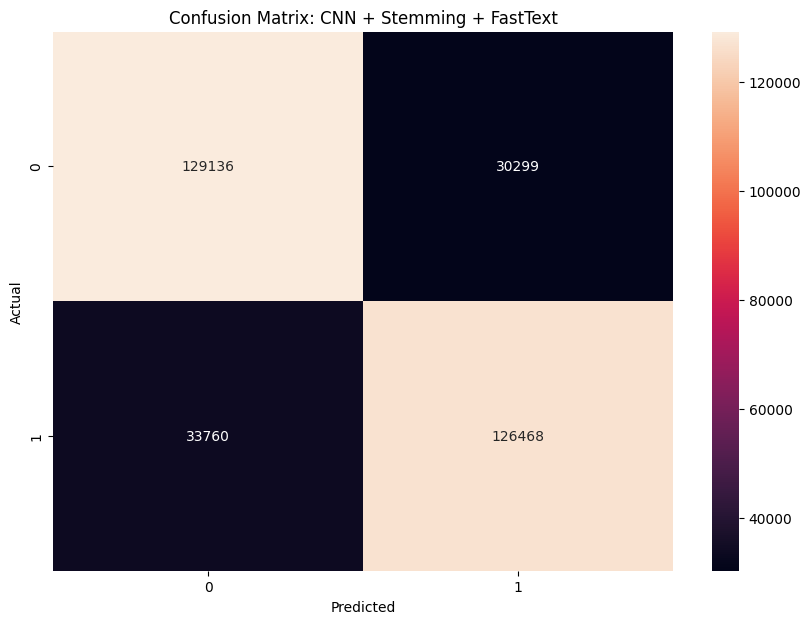

In [108]:
# Exemple pour CNN avec stemming + FastText
model_name = "cnn_model_stem_ft"
mlflow_base_dir = os.path.join(base_dir, model_name)

if not os.path.exists(mlflow_base_dir):
    os.makedirs(mlflow_base_dir)

mlflow.set_tracking_uri(f"file:///{mlflow_base_dir.replace(os.sep, '/')}")

mlflow.set_experiment(model_name)

with mlflow.start_run():
    cnn_model_stem_ft = create_cnn_model(len(tokenizer_stem.word_index) + 1, embedding_matrix_stem_ft)
    cnn_model_stem_ft.fit(X_train_stem, y_train_stem, batch_size=64, epochs=10, validation_split=0.2, verbose=1)

    mlflow.keras.log_model(cnn_model_stem_ft, model_name)

    y_pred_stem_ft = (cnn_model_stem_ft.predict(X_test_stem) > 0.5).astype("int32")
    cnn_accuracy_stem_ft = accuracy_score(y_test_stem, y_pred_stem_ft)
    cnn_precision_stem_ft = precision_score(y_test_stem, y_pred_stem_ft)
    cnn_recall_stem_ft = recall_score(y_test_stem, y_pred_stem_ft)
    cnn_f1_stem_ft = f1_score(y_test_stem, y_pred_stem_ft)

    mlflow.log_metrics({
        "accuracy": cnn_accuracy_stem_ft,
        "precision": cnn_precision_stem_ft,
        "recall": cnn_recall_stem_ft,
        "f1_score": cnn_f1_stem_ft
    })

    cm_stem_ft = confusion_matrix(y_test_stem, y_pred_stem_ft)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_stem_ft, annot=True, fmt='d')
    plt.title("Confusion Matrix: CNN + Stemming + FastText")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


D:\Master_Openclassroom\python\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 840s 52ms/step - accuracy: 0.7407 - loss: 0.5190 - val_accuracy: 0.7905 - val_loss: 0.4468
Epoch 2/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 839s 53ms/step - accuracy: 0.7893 - loss: 0.4480 - val_accuracy: 0.8012 - val_loss: 0.4286
Epoch 3/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 829s 52ms/step - accuracy: 0.8009 - loss: 0.4295 - val_accuracy: 0.8076 - val_loss: 0.4169
Epoch 4/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 836s 52ms/step - accuracy: 0.8071 - loss: 0.4184 - val_accuracy: 0.8117 - val_loss: 0.4102
Epoch 5/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 838s 52ms/step - accuracy: 0.8122 - loss: 0.4092 - val_accuracy: 0.8144 - val_loss: 0.4064
Epoch 6/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 837s 52ms/step - accuracy: 0.8144 - loss: 0.4045 - val_accuracy: 0.8153 - val_loss: 0.4059
Epoch 7/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 845s 53ms/step - accuracy: 0.8185 - loss: 0.3982 - val_accuracy: 0.8181 - val_loss: 0.4008
Epoch 8/10
15984/15984 ━━━━━━━━━━━━━━━━━━━━ 857s 54ms/s

2024/09/03 00:22:06 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/09/03 00:22:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


9990/9990 ━━━━━━━━━━━━━━━━━━━━ 165s 16ms/step


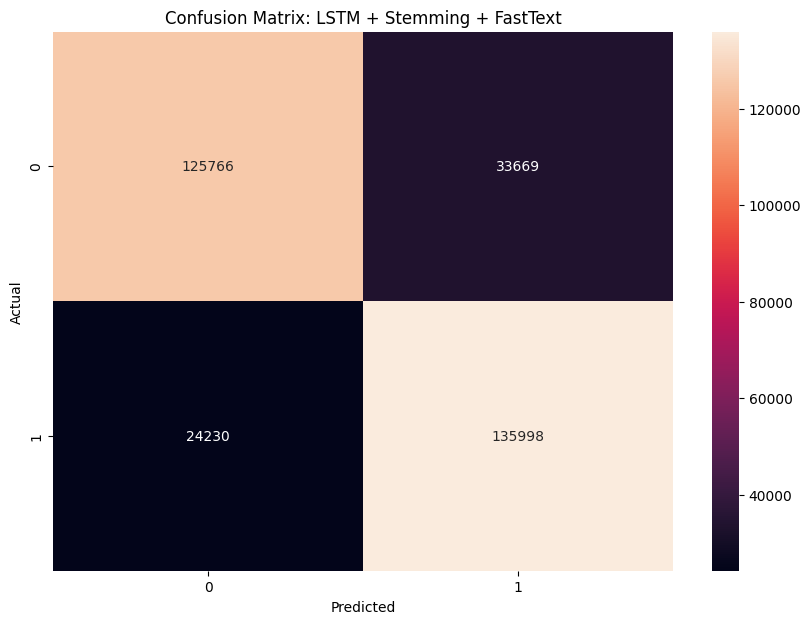

In [112]:
# Exemple pour LSTM avec stemming + FastText
model_name = "lstm_model_stem_ft"
mlflow_base_dir = os.path.join(base_dir, model_name)

if not os.path.exists(mlflow_base_dir):
    os.makedirs(mlflow_base_dir)

mlflow.set_tracking_uri(f"file:///{mlflow_base_dir.replace(os.sep, '/')}")

mlflow.set_experiment(model_name)

with mlflow.start_run():
    lstm_model_stem_ft = create_lstm_model(len(tokenizer_stem.word_index) + 1, embedding_matrix_stem_ft)
    lstm_model_stem_ft.fit(X_train_stem, y_train_stem, batch_size=64, epochs=10, validation_split=0.2, verbose=1)

    mlflow.keras.log_model(lstm_model_stem_ft, model_name)

    y_pred_stem_ft = (lstm_model_stem_ft.predict(X_test_stem) > 0.5).astype("int32")
    lstm_accuracy_stem_ft = accuracy_score(y_test_stem, y_pred_stem_ft)
    lstm_precision_stem_ft = precision_score(y_test_stem, y_pred_stem_ft)
    lstm_recall_stem_ft = recall_score(y_test_stem, y_pred_stem_ft)
    lstm_f1_stem_ft = f1_score(y_test_stem, y_pred_stem_ft)

    mlflow.log_metrics({
        "accuracy": lstm_accuracy_stem_ft,
        "precision": lstm_precision_stem_ft,
        "recall": lstm_recall_stem_ft,
        "f1_score": lstm_f1_stem_ft
    })

    cm_stem_ft = confusion_matrix(y_test_stem, y_pred_stem_ft)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_stem_ft, annot=True, fmt='d')
    plt.title("Confusion Matrix: LSTM + Stemming + FastText")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


# 6. Comparaison des modèles

In [119]:
import pandas as pd

# Initialiser une liste pour stocker les résultats
results = []

# Fonction pour ajouter les résultats d'un modèle à la liste
def log_results(model_name, accuracy, precision, recall, f1):
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

# Log des résultats pour les modèles avancés (Word2Vec + FastText)

# CNN + Lemmatization + Word2Vec
log_results(
    'CNN + Lemmatization + Word2Vec',
    accuracy_lemma_w2v,
    precision_lemma_w2v,
    recall_lemma_w2v,
    f1_lemma_w2v
)

# LSTM + Lemmatization + Word2Vec
log_results(
    'LSTM + Lemmatization + Word2Vec',
    lstm_accuracy_lemma_w2v,
    lstm_precision_lemma_w2v,
    lstm_recall_lemma_w2v,
    lstm_f1_lemma_w2v
)

# CNN + Stemming + Word2Vec
log_results(
    'CNN + Stemming + Word2Vec',
    cnn_accuracy_stem_w2v,
    cnn_precision_stem_w2v,
    cnn_recall_stem_w2v,
    cnn_f1_stem_w2v
)

# LSTM + Stemming + Word2Vec
log_results(
    'LSTM + Stemming + Word2Vec',
    lstm_accuracy_stem_w2v,
    lstm_precision_stem_w2v,
    lstm_recall_stem_w2v,
    lstm_f1_stem_w2v
)

# CNN + Lemmatization + FastText
log_results(
    'CNN + Lemmatization + FastText',
    cnn_accuracy_lemma_ft,
    cnn_precision_lemma_ft,
    cnn_recall_lemma_ft,
    cnn_f1_lemma_ft
)

# LSTM + Lemmatization + FastText
log_results(
    'LSTM + Lemmatization + FastText',
    lstm_accuracy_lemma_ft,
    lstm_precision_lemma_ft,
    lstm_recall_lemma_ft,
    lstm_f1_lemma_ft
)

# CNN + Stemming + FastText
log_results(
    'CNN + Stemming + FastText',
    cnn_accuracy_stem_ft,
    cnn_precision_stem_ft,
    cnn_recall_stem_ft,
    cnn_f1_stem_ft
)

# LSTM + Stemming + FastText
log_results(
    'LSTM + Stemming + FastText',
    lstm_accuracy_stem_ft,
    lstm_precision_stem_ft,
    lstm_recall_stem_ft,
    lstm_f1_stem_ft
)

# Convertir les résultats en DataFrame
results_df = pd.DataFrame(results)

# Afficher le tableau récapitulatif
print(results_df)



                             Model  Accuracy  Precision    Recall  F1 Score
0   CNN + Lemmatization + Word2Vec  0.805135   0.814140  0.792053  0.802945
1  LSTM + Lemmatization + Word2Vec  0.829276   0.826589  0.834461  0.830506
2        CNN + Stemming + Word2Vec  0.794033   0.788292  0.805384  0.796746
3       LSTM + Stemming + Word2Vec  0.818431   0.818215  0.819925  0.819069
4   CNN + Lemmatization + FastText  0.804028   0.849342  0.740351  0.791110
5  LSTM + Lemmatization + FastText  0.829746   0.820288  0.845589  0.832746
6        CNN + Stemming + FastText  0.799605   0.806726  0.789300  0.797918
7       LSTM + Stemming + FastText  0.818875   0.801558  0.848778  0.824493


# 7. Export du Modèle

In [124]:
import os
import joblib

# Supposez que vous avez un dictionnaire avec les accuracies des modèles
accuracies = {
    'CNN + Lemmatization + Word2Vec': accuracy_lemma_w2v,
    'CNN + Lemmatization + FastText': cnn_accuracy_lemma_ft,
    'CNN + Stemming + Word2Vec': cnn_accuracy_stem_w2v,
    'CNN + Stemming + FastText': cnn_accuracy_stem_ft,
    'LSTM + Lemmatization + Word2Vec': lstm_accuracy_lemma_w2v,
    'LSTM + Lemmatization + FastText': lstm_accuracy_lemma_ft,
    'LSTM + Stemming + Word2Vec': lstm_accuracy_stem_w2v,
    'LSTM + Stemming + FastText': lstm_accuracy_stem_ft,
}

# Déterminez le meilleur modèle basé sur les accuracies
best_model_name = max(accuracies, key=accuracies.get)

# Selon le meilleur modèle, sélectionnez l'objet modèle correspondant
if best_model_name == 'CNN + Lemmatization + Word2Vec':
    best_model = cnn_model_lemma_w2v
elif best_model_name == 'CNN + Lemmatization + FastText':
    best_model = cnn_model_lemma_ft
elif best_model_name == 'CNN + Stemming + Word2Vec':
    best_model = cnn_model_stem_w2v
elif best_model_name == 'CNN + Stemming + FastText':
    best_model = cnn_model_stem_ft
elif best_model_name == 'LSTM + Lemmatization + Word2Vec':
    best_model = lstm_model_lemma_w2v
elif best_model_name == 'LSTM + Lemmatization + FastText':
    best_model = lstm_model_lemma_ft
elif best_model_name == 'LSTM + Stemming + Word2Vec':
    best_model = lstm_model_stem_w2v
elif best_model_name == 'LSTM + Stemming + FastText':
    best_model = lstm_model_stem_ft

# Créez le chemin vers le dossier 'models'
models_folder_path = os.path.join('..', 'models')

# Créez le dossier 'models' s'il n'existe pas
if not os.path.exists(models_folder_path):
    os.makedirs(models_folder_path)

# Sauvegardez le modèle dans le dossier 'models'
model_file_name = f"{best_model_name.replace(' ', '_').replace('+', 'plus')}_model.h5"
model_path = os.path.join(models_folder_path, model_file_name)
best_model.save(model_path)

print(f"Best model '{best_model_name}' saved at {model_path}")


Best model 'LSTM + Lemmatization + FastText' saved at ..\models\LSTM_plus_Lemmatization_plus_FastText_model.h5
